# SUE Exploritory Data Analysis

This dataset contains NetFlow data that is collected from a Kubernetes cluster. The cluster is used to monitor the microservice applications that are running on the cluster. The goal is to use the (NetFlow) logs to learn a state machine model that models the normal network behaviour within the cluster. The state machine model is then used to monitor and detect potential anomalies that might occur during the runtime of the cluster.

This dataset contains both benign data (produced by real-life users) and malicious data (produced by launching several attacks against the clusters). The label of each flow is included in the dataset.


In [60]:
!pip install pandas-profiling
!pip install nbconvert
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.4 MB/s eta 0:00:00


In [58]:
#Importing all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import nbformat
from nbconvert import HTMLExporter
from google.colab import drive

<ipython-input-58-380b0f49c22f>:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## Importing of data

For the collection of data, the cluster is setup with three main microservice applications and several different services. The three main microservice applications are the following:
- Guestbook Application: a front-end application that allows users to read messages that were written by other users and write messages of their own. The messages are all presented on a web page.
- Joomla Blog Application: an application that allows users to write and read blog posts. This application is very similar to a WordPress blog.
- OpenSSH server: a tool that allows users to connect to the cluster remotely using an SSH connection. The user can execute commands once they have successfully logged in.

SUE set up several experiments in which real-life users are allowed to use the deployed applications normally. Their network behaviours are used to collect benign data. For the collection of malicious data, they launch several attacks during an experiment. The three microservice applications are the main targets of the attacks. Elasticsearch (specifically Packetbeat) is used to collect and extract the NetFlow data from the cluster. As real-life users are involved in our experiments, they have anonymised all IP addresses in the dataset to prevent the identification of the users.   

In [4]:
# Mounting the google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset is located in the drive and was provided by SUE representative. It can be found also here: https://data.4tu.nl/articles/dataset/AssureMOSS_Kubernetes_Run-time_Monitoring_Dataset/20463687

Each CSV file contains labelled NetFlow data collected from the kubernetes cluster. From the list of files, only two files (`elastic_may21_benign_data.csv` and `elastic_may21_malicious_data.csv`) do not contain network behaviours that were produced by real-life users. The former file contains only normal data that was produced by the applications and services and the latter file contains both data produced by the applications, services and attacks.

Each file with a name in the following format, `elastic_MONTHYEAR_data.csv`, contains NetFlow data collected from a particular experiment. Throughout the project, we will carry out more experiments and we will add the collected data to this repository.

## Reading the data

In [5]:
# The dataset can be found in Fontys/data and its imported here
df = pd.read_csv('/content/drive/My Drive/Fontys/data/elastic_february2022_data.csv')
df.head(5)

,_source_flow_id,_source_flow_final,_source_source_ip,_source_destination_ip,_source_network_bytes,_source_network_transport,_source_@timestamp,_source_event_duration,_source_destination_port,_source_source_port,label
0,EAD/////AP////////8AAAGsEAILrBACDA,False,240.16.203.232,240.16.203.236,72096053,NaN,2022-02-25T12:20:00.007Z,41753051589,NaN,NaN,benign
1,EAD/////AP////////8AAAGsEAIKrBACDA,False,240.16.203.236,240.16.203.233,913734,NaN,2022-02-25T12:20:00.007Z,35268442180,NaN,NaN,benign
2,EAT/////AP//////CP8AAAHAqFSDwKj3AAEIbQI,False,190.215.171.30,190.215.9.27,30684984,tcp,2022-02-25T12:20:00.007Z,41662926223,621.0,2049.0,benign
3,EAT/////AP//////CP8AAAHAqFSPwKj3D8CeVCQ,False,190.215.171.17,190.215.9.16,220136,tcp,2022-02-25T12:20:00.007Z,41154340691,9300.0,40640.0,benign
4,EAT/////AP//////CP8AAAEKapNUwKj3DvAjvpo,False,190.215.9.17,53.181.234.140,73242,tcp,2022-02-25T12:20:00.007Z,41259502779,9200.0,39614.0,benign


First important thing is to understand the content of the data and its features. We start by seeing the shape of the dataset:

In [10]:
df.shape

(398414, 11)

We see that the elastic_february2022_data dataset contains almost 400k rows and 11 columns. We can further explore the columns and their data type.

In [8]:
df.dtypes

_source_flow_id               object
_source_flow_final              bool
_source_source_ip             object
_source_destination_ip        object
_source_network_bytes          int64
_source_network_transport     object
_source_@timestamp            object
_source_event_duration         int64
_source_destination_port     float64
_source_source_port          float64
label                         object
dtype: object

Since we have to convert the objects to numeric data in order to feed the model, we can see how many unique values there are for each object feature.

In [50]:
# loop that goes through the object columns and print the length of unique values
for column in df.select_dtypes(include=["object"]).columns:
  print(column,len(df[column].unique()))

_source_flow_id 47382
_source_source_ip 81
_source_destination_ip 77
_source_network_transport 5
_source_@timestamp 1244
label 2


Based on the results we can easily convert 2 object features to numeric - network_transport and label. The ips have around 80 unique values, meaning most of the request come from the same ips. the timestamp and flow id are not relevant in this case.

Next step is to see if there are any null values in specific columns:

In [15]:
missing_values = df.isnull().sum()
missing_values

_source_flow_id                 0
_source_flow_final              0
_source_source_ip               0
_source_destination_ip          0
_source_network_bytes           0
_source_network_transport    2334
_source_@timestamp              0
_source_event_duration          0
_source_destination_port     2557
_source_source_port          2557
label                           0
dtype: int64

We can see that the network transport, destination and source port contain null or NaN values. We store them in one variable so they can be easily accessible later on.

In [16]:
missing_values = missing_values[missing_values > 0]
missing_values

_source_network_transport    2334
_source_destination_port     2557
_source_source_port          2557
dtype: int64

Before going forward to visualizing the data, we can observe again the first and last rows:

In [17]:
df.head(10)

,_source_flow_id,_source_flow_final,_source_source_ip,_source_destination_ip,_source_network_bytes,_source_network_transport,_source_@timestamp,_source_event_duration,_source_destination_port,_source_source_port,label
0,EAD/////AP////////8AAAGsEAILrBACDA,False,240.16.203.232,240.16.203.236,72096053,NaN,2022-02-25T12:20:00.007Z,41753051589,NaN,NaN,benign
1,EAD/////AP////////8AAAGsEAIKrBACDA,False,240.16.203.236,240.16.203.233,913734,NaN,2022-02-25T12:20:00.007Z,35268442180,NaN,NaN,benign
2,EAT/////AP//////CP8AAAHAqFSDwKj3AAEIbQI,False,190.215.171.30,190.215.9.27,30684984,tcp,2022-02-25T12:20:00.007Z,41662926223,621.0,2049.0,benign
3,EAT/////AP//////CP8AAAHAqFSPwKj3D8CeVCQ,False,190.215.171.17,190.215.9.16,220136,tcp,2022-02-25T12:20:00.007Z,41154340691,9300.0,40640.0,benign
4,EAT/////AP//////CP8AAAEKapNUwKj3DvAjvpo,False,190.215.9.17,53.181.234.140,73242,tcp,2022-02-25T12:20:00.007Z,41259502779,9200.0,39614.0,benign
5,EAT/////AP//////CP8AAAHAqPcOwKj3D76a8CM,False,190.215.9.17,190.215.9.16,73242,tcp,2022-02-25T12:20:00.007Z,41259470074,9200.0,39614.0,benign
6,EAT/////AP//////CP8AAAHAqFSPwKj3D1QkHoU,False,190.215.9.16,190.215.171.17,8722579,tcp,2022-02-25T12:20:00.007Z,41452819204,9300.0,34078.0,benign
7,EAT/////AP//////CP8AAAEKapNUwKj3DvAjiL0,False,190.215.9.17,53.181.234.140,185527,tcp,2022-02-25T12:20:00.007Z,41259083382,9200.0,48520.0,benign
8,EAT/////AP//////CP8AAAHAqPcOwKj3D4i98CM,False,190.215.9.17,190.215.9.16,185527,tcp,2022-02-25T12:20:00.007Z,41259090925,9200.0,48520.0,benign
9,EAT/////AP//////CP8AAAEKapNUwKj3DvAjir0,False,190.215.9.17,53.181.234.140,259049,tcp,2022-02-25T12:20:00.007Z,41255227153,9200.0,48522.0,benign


In [18]:
df.tail(10)

,_source_flow_id,_source_flow_final,_source_source_ip,_source_destination_ip,_source_network_bytes,_source_network_transport,_source_@timestamp,_source_event_duration,_source_destination_port,_source_source_port,label
398404,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,True,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,19748,9099.0,51904.0,benign
398405,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,True,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,156753,9099.0,51920.0,benign
398406,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,True,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,23294,9099.0,51932.0,benign
398407,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,True,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,67367,9099.0,51948.0,benign
398408,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,True,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,19045,9099.0,51960.0,benign
398409,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,True,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,23101,9099.0,51980.0,benign
398410,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,18591,9099.0,52008.0,benign
398411,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,19850,9099.0,52024.0,benign
398412,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,35017,9099.0,52040.0,benign
398413,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,33292,9099.0,52070.0,benign


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['_source_event_duration'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['_source_source_port'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_2, *['_source_event_duration'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_3, *['_source_source_port'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_4, *['_source_flow_final'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_5, *[[['_source_event_duration', '_source_source_port']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_6, *['_source_event_duration', '_source_flow_final'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_7, *['_source_source_port', '_source_flow_final'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_8, *['_source_network_bytes', '_source_event_duration', '_source_flow_final'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_9, *['_source_network_bytes', 'count()', '_source_flow_final'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_10, *['_source_@timestamp', '_source_event_duration', '_source_flow_final'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_11, *['_source_@timestamp', 'count()', '_source_flow_final'], **{})
chart

The main thing that can be observed by comparing the first and last rows is the difference in ip addresses. Also it seems like that the dataset contain 2 hours of logs, starting from 12:20 until 14:09 on the same day.

Let's visualize the data.

## Functions Definition

Here I will define functions for different visualizations, which can be easily called later on without copy/pasting code.

In [11]:
# For plotting histogram for a numeric feature
def plot_histogram(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Histogram for {column_name}')
    plt.show()

In [1]:
# Getting the unique labels
def get_unique_labels(df, column_name):
    labels = df[column_name].unique()
    print(f"Unique labels for {column_name}: {labels}")
    print(f"Total unique labels for {column_name}: {len(labels)}")

In [20]:
# For plotting bar chart for a categorical feature
def plot_bar_chart(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column_name)
    plt.title(f'Bar Chart for {column_name}')
    plt.xticks(rotation=45)
    plt.show()

In [51]:
# For plotting correlation heatmap
def plot_correlation_heatmap(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()

<ipython-input-51-02408819b84b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [42]:
def plot_dist(df, column):
  sns.distplot(df[column])
  plt.title('Dist Plot')
  plt.show()

In [52]:
def box_plots_for_numeric(df):
  numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
  for column in numeric_columns:
    sns.boxplot(df[column])
    plt.title(f'Box Plot for {column}')
    plt.show()

In [54]:
def cluster_map(df):
  correlation_matrix = df.corr()
  sns.clustermap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
  plt.show()

## Visualization

Starting with the labeled data, we can call the bar chart function to observe its values.

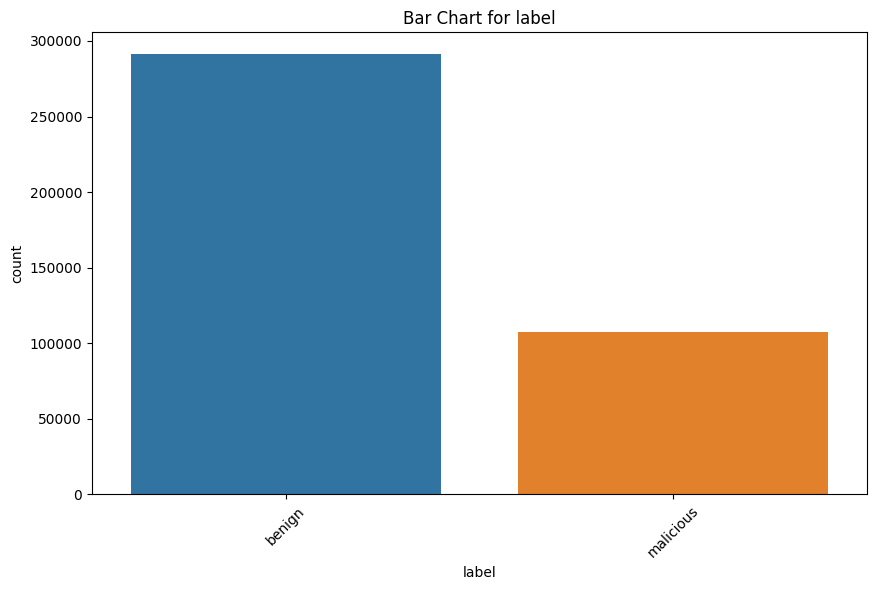

In [21]:
plot_bar_chart(df, "label")

We see that the label column is not balanced, meaning there are more benign requests than malicious. It is important to either reduce the benign data, or generate more malicious data before feeding the model, as it may produce (most of the time) biased results. Deleting data should be avoided as much as possible 😜

To see the correlation between the features, we can plot a heatmap

<ipython-input-19-7f5642ff9e94>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)


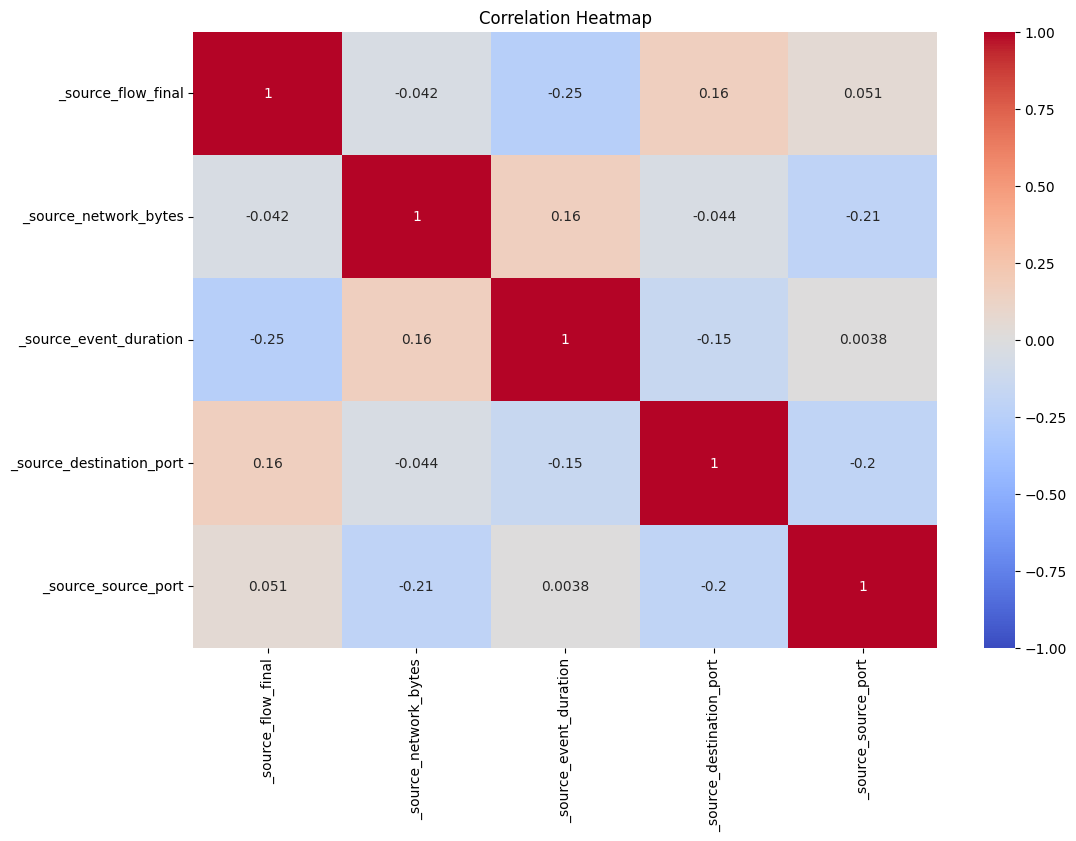

In [22]:
plot_correlation_heatmap(df)

Based on the correlation matrix, there is no direct correlation (or at least big one) between the features. The highest correlation is between the event duration and the final flow, but its still -0.25, which is relatively low. We can try to create a scatter plot for some features:

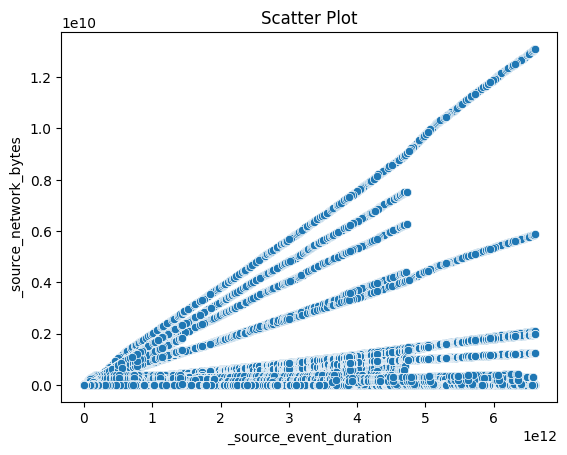

In [30]:
sns.scatterplot(x=df['_source_event_duration'], y=df['_source_network_bytes'])
plt.title('Scatter Plot')
plt.show()

Looking at the scatterplot, we can not observe any obvious patterns or clusters of data. Therefore at this stage is useless to scatterplot the other features with such low correlation.

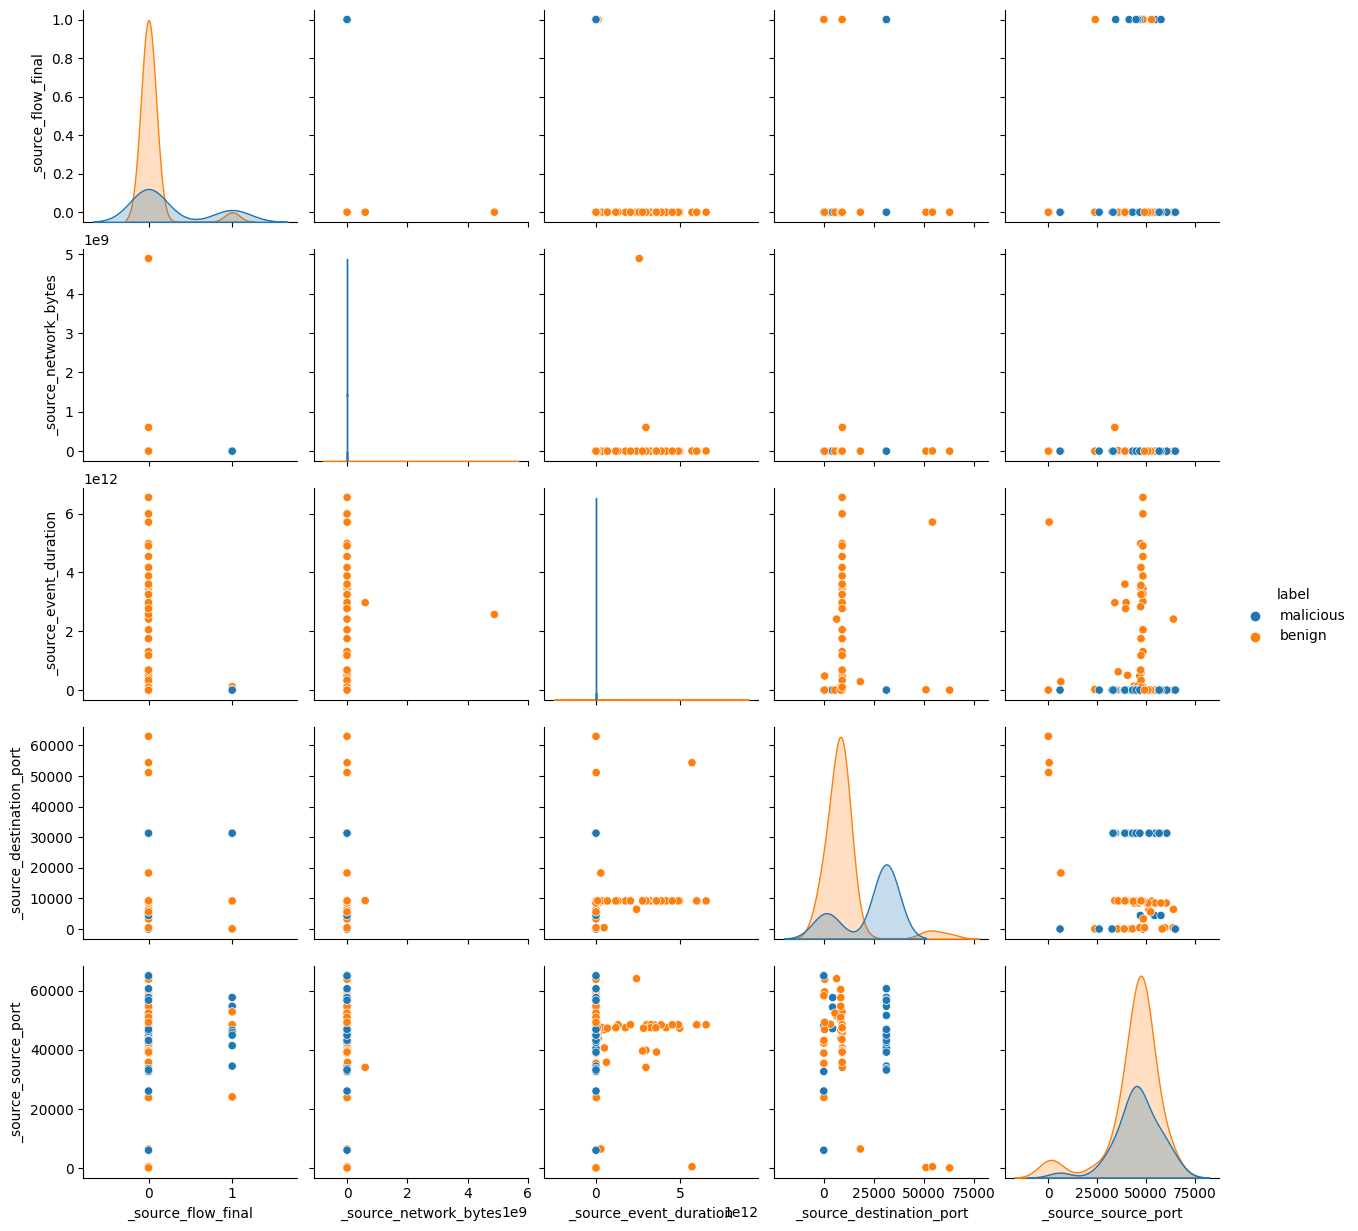

In [41]:
# Generating a pairplot to see the relationship between the features
# A sample of 100 rows is used from the dataset, otherwise it will load for hours
# The color represents the label - benign or malicious
sns.pairplot(df.sample(100), hue="label")
plt.show()

Again we can not observe obvious relation between the features. The only one close to grouping the two labels are the _source_destination_port with _source_source_port features.

<ipython-input-42-b8d19076ef3c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


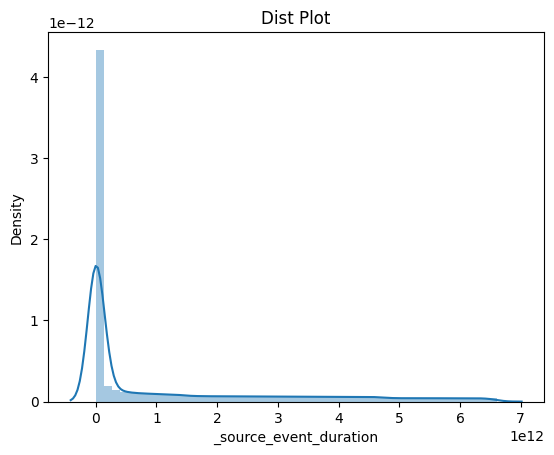

In [43]:
plot_dist(df,"_source_event_duration")

With a distribution plot we can observe that most of the data for source_event_duration is around 0. The x values is the event duration in miliseconds (1e12 = 1x10 power 12 = 1 trillion). The x values shows the density of the event duration (mostly at the beginning).

Let's generate box plots for each numeric feature in the dataset. It will show for each column the position and occurance of data.

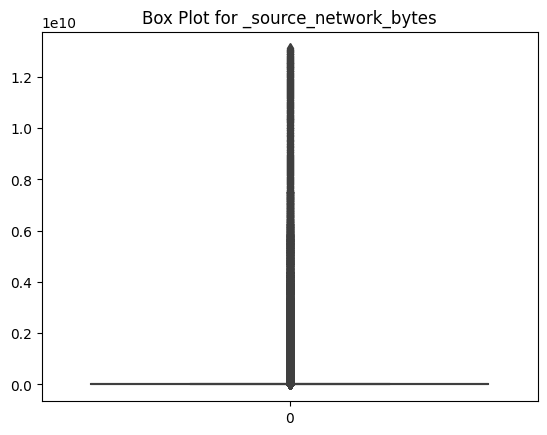

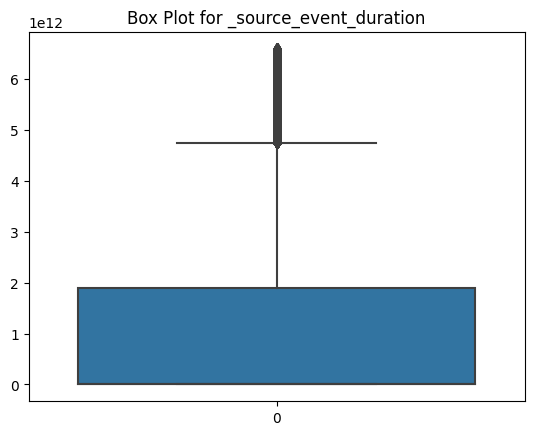

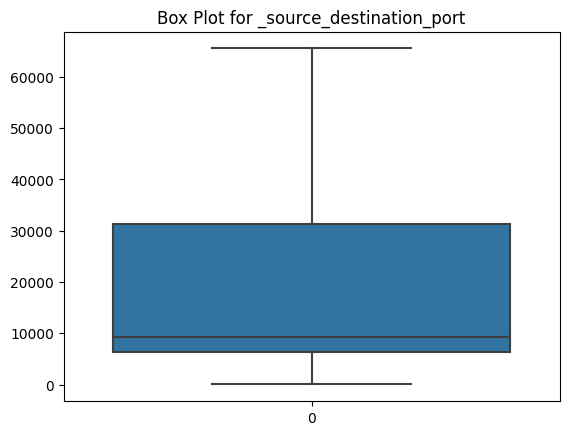

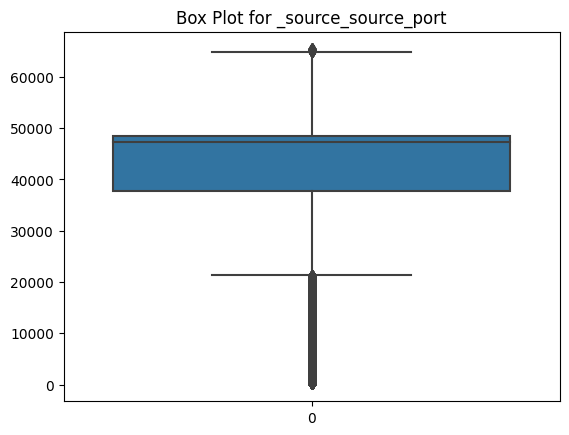

In [53]:
box_plots_for_numeric(df)

Based on the boxplots we see that there are some outliners. For example, in the plot for event duration, most of the data is between 0 and 2 trillion. However, there are datapoints at 5 trillion and above which makes the data difficult to visualize. We can also observe the same thing for the network bytes.

## Pandas Report

In [59]:
# Generating the report
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

# Saving the report to an HTML file
profile.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Next steps

The next steps are:
- Further explore the data (which features we may use, why, other useful plots, clean the notebook if needed)
- Clean the data from NaN values (delete, generate new data or don't use the columns)
- Normalize the data. Some features contain very large numbers, while other don't. For example the event duration and ports, there is quite big difference in values.
- Convert categorical data to number data. For example, instead of the label column to be either "benign" or "malicious", we can add 2 columns, one for benign and one for malicious requests, where their value will be either 0 or 1.
- Balance the labeled data. Now there are much more benign requests than malicious ones.
- Test the updated dataset with the plots and see if there is any difference

## Export

In [64]:
# Load the notebook
with open("/content/drive/MyDrive/Fontys/eda.ipynb", "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

# Convert to HTML
html_exporter = HTMLExporter()
html_data, _ = html_exporter.from_notebook_node(notebook)

# Save the HTML data to a file
with open("/content/drive/MyDrive/Fontys/eda.html", "w", encoding="utf-8") as f:
    f.write(html_data)